**Install + Load libraries**

In [1]:
! [ -e /content ] && pip install -Uqq fastai --quiet # upgrade fastai on colab 

     |████████████████████████████████| 189 kB 4.0 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 


In [2]:
#export
from fastai.imports import *
from fastai.torch_imports import *
from packaging.version import parse

In [3]:

from fastai.vision.all import *

In [4]:
from fastcore.transform import Pipeline

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, IntToFloatTensor, Normalize, RandomSplitter, ToTensor, parent_label

from fastai.torch_core import to_device

from fastai.vision.augment import aug_transforms, Resize, RandomResizedCrop, FlipItem
from fastai.vision.data import ImageBlock, PILImage, get_image_files, imagenet_stats

In [5]:
from PIL import Image

In [6]:
!pip install rasterio --quiet

     |████████████████████████████████| 19.3 MB 347 kB/s 


In [7]:
!pip install geopandas --quiet

     |████████████████████████████████| 1.0 MB 3.9 MB/s 
     |████████████████████████████████| 16.7 MB 53.8 MB/s 
     |████████████████████████████████| 6.3 MB 49.4 MB/s 


In [8]:
from typing import Tuple
import rasterio as rio
import geopandas as gpd

In [9]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Load datasets from Drive
!unzip /content/drive/MyDrive/Datasets/PD/S2S112B_datasetV.zip

Archive:  /content/drive/MyDrive/Datasets/PD/S2S112B_datasetV.zip
 extracting: S2S112B_dataset/codes.txt  
   creating: S2S112B_dataset/labels/
  inflating: S2S112B_dataset/labels/osa_10_0.tif  
  inflating: S2S112B_dataset/labels/osa_10_1.tif  
  inflating: S2S112B_dataset/labels/osa_10_10.tif  
  inflating: S2S112B_dataset/labels/osa_10_11.tif  
  inflating: S2S112B_dataset/labels/osa_10_15.tif  
  inflating: S2S112B_dataset/labels/osa_10_2.tif  
  inflating: S2S112B_dataset/labels/osa_10_6.tif  
  inflating: S2S112B_dataset/labels/osa_10_8.tif  
  inflating: S2S112B_dataset/labels/osa_105_12.tif  
  inflating: S2S112B_dataset/labels/osa_106_4.tif  
  inflating: S2S112B_dataset/labels/osa_108_12.tif  
  inflating: S2S112B_dataset/labels/osa_108_4.tif  
  inflating: S2S112B_dataset/labels/osa_109_1.tif  
  inflating: S2S112B_dataset/labels/osa_109_10.tif  
  inflating: S2S112B_dataset/labels/osa_109_11.tif  
  inflating: S2S112B_dataset/labels/osa_109_15.tif  
  inflating: S2S112B_dat

In [11]:
#Classes for loading multi-channel bands

def open_npy(fn, chans=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    return im

def open_geotiff(fn, chans=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    return im

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[1], ctx=None, vmin=None, vmax=None, **kwargs):
        "These need refactoring"
        if len(channels) == 3: 
            return show_composite(self, channels=channels, ctx=ctx, vmin=vmin, vmax=vmax,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1: 
            return show_single_channel(self, channel=channels[0], ctx=ctx, 
                                       **{**self._show_args, **kwargs})

    @classmethod
    def create(cls, fn, chans=None,  **kwargs) ->None:
        if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans))
        elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans))
        
    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'
    
MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create) 
        
def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]
    if scale: im = norm(im, vmin, vmax)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None, 
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], vmin=tempim[channel].min(), vmax=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax
        
        
def norm(vals, vmin=None, vmax=None):
    """
    For visualization purposes normalize image with `(vals-vmin)/(vmax-vmin), 
    with vals either specified or within 0.01 and 0.99 quantiles of all values
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01))
    vmax = ifnone(vmax, np.quantile(vals, 0.99))
    return (vals - vmin)/(vmax-vmin)

In [12]:
#visualize a single TIF image
TEST_TIF = '/content/S2S112B_dataset/S2S112B/osa_105_12.tif'
tif_img = MultiChannelTensorImage.create(TEST_TIF)
tif_img

MultiChannelTensorImage size=12x256x256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


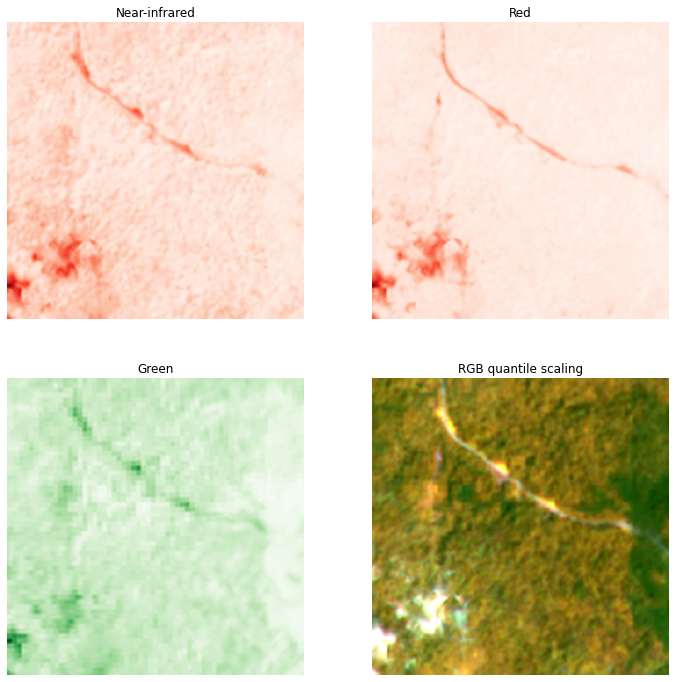

In [13]:
#plot a multichannel image, set the bands you want to visualize
_, ax = plt.subplots(2,2, figsize=(12,12))
tif_img.show(channels=[1], ax=ax[0,0], figsize=(6,6), title='Near-infrared', cmap='Reds')
tif_img.show(channels=[2], ax=ax[0,1], figsize=(6,6), title='Red', cmap='Reds')
tif_img.show(channels=[3], ax=ax[1,0], figsize=(6,6), title='Green', cmap='Greens')
tif_img.show(channels=(3,1,2), ax=ax[1,1], title='RGB quantile scaling', figsize=(6,6), scale=True)
# tif_img.show(channels=(3,2), ax=ax[0,1], title='NDVI', figsize=(6,6), cmap='RdYlGn_r')
# tif_img.show(channels=(3,2,1), ax=ax[1,0], title='RGB manual scaling', figsize=(6,6), scale=True, 
#              vmin=np.array([0,0,0]), vmax=np.array([255,255,255]))
# tif_img.show(channels=(1,2,3), ax=ax[1,1], title='RGB quantile scaling', figsize=(6,6), scale=True)

In [14]:
#define all band datablock
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans))

In [15]:
#set all band datablock
tif = DataBlock(blocks=(MultiChannelImageBlock()), get_items=partial(get_files, extensions='.tif', recurse=False), splitter=None)

In [16]:
#set paths
path_im = Path('S2S112B_dataset/S2S112B')
path_lbl = Path('S2S112B_dataset/labels')

In [17]:
tif_dls = tif.dataloaders(source=path_im, bs=1)
tif_dls.items

[Path('S2S112B_dataset/S2S112B/rp_175_8.tif'),
 Path('S2S112B_dataset/S2S112B/osa_38_8.tif'),
 Path('S2S112B_dataset/S2S112B/rp_320_14.tif'),
 Path('S2S112B_dataset/S2S112B/osa_42_6.tif'),
 Path('S2S112B_dataset/S2S112B/rp_806_3.tif'),
 Path('S2S112B_dataset/S2S112B/rp_248_6.tif'),
 Path('S2S112B_dataset/S2S112B/rp_327_11.tif'),
 Path('S2S112B_dataset/S2S112B/rp_76_14.tif'),
 Path('S2S112B_dataset/S2S112B/rp_645_9.tif'),
 Path('S2S112B_dataset/S2S112B/rp_766_10.tif'),
 Path('S2S112B_dataset/S2S112B/osa_38_6.tif'),
 Path('S2S112B_dataset/S2S112B/rp_147_3.tif'),
 Path('S2S112B_dataset/S2S112B/rp_416_12.tif'),
 Path('S2S112B_dataset/S2S112B/osa_44_1.tif'),
 Path('S2S112B_dataset/S2S112B/osa_143_13.tif'),
 Path('S2S112B_dataset/S2S112B/rp_383_6.tif'),
 Path('S2S112B_dataset/S2S112B/osa_20_1.tif'),
 Path('S2S112B_dataset/S2S112B/osa_45_7.tif'),
 Path('S2S112B_dataset/S2S112B/osa_60_12.tif'),
 Path('S2S112B_dataset/S2S112B/osa_57_0.tif'),
 Path('S2S112B_dataset/S2S112B/osa_85_11.tif'),
 Path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


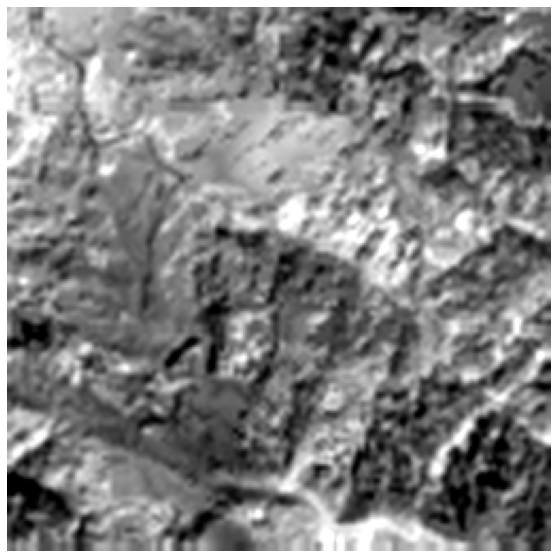

In [18]:
#check image from datablock
ctxs = tif_dls.show_batch(channels=(6,6,6), figsize=(10,10))


In [19]:
def _using_attr(f, attr, x):
    return f(getattr(x,attr))

In [20]:
def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

In [21]:
#define multichannel data loader

class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, extensions=['.tif'], 
                    train='train', valid='valid', valid_pct=None, seed=None, 
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, extensions=['.tif'], 
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.   
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)
    
    @classmethod
    def from_name_func(cls, path, fnames, label_func, 
                       chans=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, valid_pct=0.2, seed=None, 
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas.
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        return cls.from_df(df, path=path, chans=chans, **kwargs)
    
    @classmethod
    def from_csv(cls, path,  chans=None, csv_fname='labels.csv', 
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels,chans=None, valid_pct=0.2, 
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`. Specify dims to be either 2 (for 2d images) or 3 (for volumetric images)
        and optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(dims=dims, chans=chans), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)
    
MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [22]:
#define method to get mask from the labels
def get_mask_from_tif(fn):
    return open_geotiff(fn, chans=[0])[0]

In [23]:
get_msk = lambda o: path_lbl/f'{o.stem}{o.suffix}'

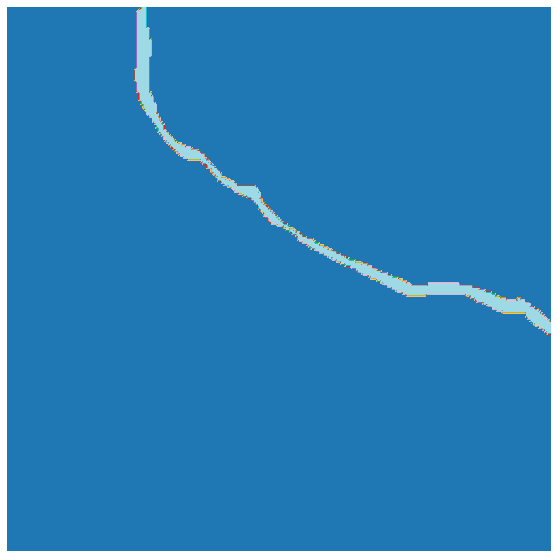

In [24]:
img_fn = '/content/S2S112B_dataset/labels/osa_105_12.tif'
msk = PILMask.create(get_mask_from_tif(img_fn))
msk.show(figsize=(10,10), alpha=1)

In [25]:
#define segmentation dataloaders incl. images and masks

#export
class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_funcs(cls, path, fnames, label_func, chans=None, 
                         extensions=['.tif'], valid_pct=None, seed=None, 
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), 
                                   MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [26]:
pathlist = Path('S2S112B_dataset')
pathlist.ls()

(#4) [Path('S2S112B_dataset/S2S112B'),Path('S2S112B_dataset/codes.txt'),Path('S2S112B_dataset/labels'),Path('S2S112B_dataset/validList.txt')]

In [27]:
codes = np.loadtxt('/content/S2S112B_dataset/codes.txt', dtype=str); codes

array(['other', 'roads'], dtype='<U5')

In [28]:
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [48]:
#testing valid dataset
segm = TifSegmentationDataLoaders.from_label_funcs(path='/content/S2S112B_dataset/S2S112B/', 
                                                   bs = 16, 
                                                   codes=codes,
                                                   fnames = get_files('/content/S2S112B_dataset/S2S112B/', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/S2S112B_dataset/labels/{o.stem}{o.suffix}'),
                                                   valid_pct=0.05,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [49]:
segm.valid_ds

(#35) [(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=12x256x256, PILMask mode=F size=256x256)...]

In [50]:
segm.one_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(MultiChannelTensorImage size=16x12x256x256,
 TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 

In [51]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [52]:
cl = CombinedLoss()

In [53]:
learn =  unet_learner(segm, resnet34, n_in=12, metrics = [JaccardCoeff(), Dice()], loss_func=cl, opt_func=ranger, self_attention=True, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0002754228771664202)

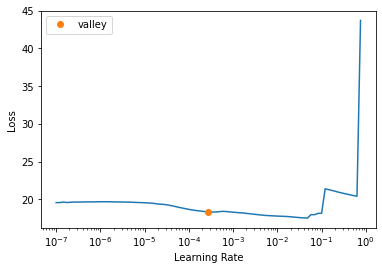

In [54]:
#find lr
learn.lr_find()

In [55]:
lr = 0.001

In [56]:
learn.fit_one_cycle(50, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,16.931562,15.116314,0.000000,0.000000,00:23
1,16.429409,15.345689,0.000000,0.000000,00:22
2,16.061756,14.685562,0.005316,0.010577,00:22
3,15.584395,14.090404,0.057188,0.108188,00:21
4,14.991833,13.614914,0.075420,0.140261,00:22
5,14.365758,13.295357,0.088030,0.161816,00:21
6,13.810471,12.681493,0.120873,0.215677,00:22
7,13.436964,12.475619,0.132235,0.233582,00:22
8,13.203648,12.093287,0.150964,0.262326,00:22
9,12.925858,12.092575,0.153983,0.266872,00:22


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


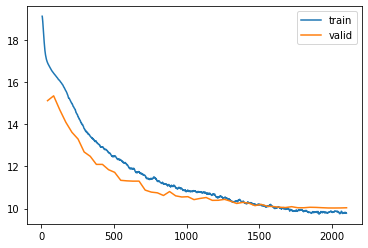

In [57]:
learn.recorder.plot_loss()

In [58]:
learn.unfreeze()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=1.0964781722577754e-06)

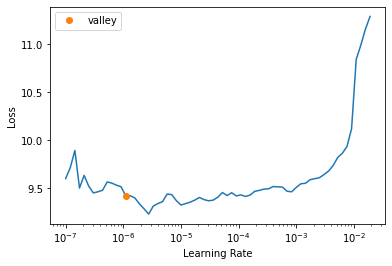

In [66]:
#find lr
learn.lr_find()

In [76]:
lr = 0.0001

In [61]:
learn.save('S2S1')

Path('/content/S2S112B_dataset/S2S112B/models/S2S1.pth')

In [75]:
learn.save('S2S1many')

Path('/content/S2S112B_dataset/S2S112B/models/S2S1many.pth')

In [77]:
learn.fit_flat_cos(20, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,9.485869,9.945455,0.244034,0.392328,00:22
1,9.401351,9.972580,0.243480,0.391611,00:22
2,9.430618,9.914851,0.245578,0.394320,00:22
3,9.436669,9.907893,0.246529,0.395545,00:21
4,9.392988,9.994587,0.242039,0.389745,00:22
5,9.426129,9.911322,0.246945,0.396080,00:22
6,9.405256,10.021740,0.241671,0.389268,00:22
7,9.402876,9.879877,0.248102,0.397566,00:22
8,9.351171,9.949051,0.244406,0.392807,00:22
9,9.351347,9.898456,0.246160,0.395070,00:22


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [73]:
learn.fit_one_cycle(0, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,9.445290,9.958007,0.244260,0.392620,00:22
1,9.454857,9.957092,0.245054,0.393645,00:22
2,9.422673,9.932862,0.245417,0.394112,00:22
3,9.428210,9.930221,0.246429,0.395416,00:22
4,9.465832,9.935385,0.244457,0.392874,00:22
5,9.458815,9.942387,0.245486,0.394202,00:22
6,9.434018,9.944760,0.244615,0.393077,00:22
7,9.435407,9.948404,0.244636,0.393105,00:22
8,9.436597,9.950952,0.244313,0.392687,00:22
9,9.444617,9.949770,0.245142,0.393758,00:22


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.fit_one_cycle(20, slice(lr))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


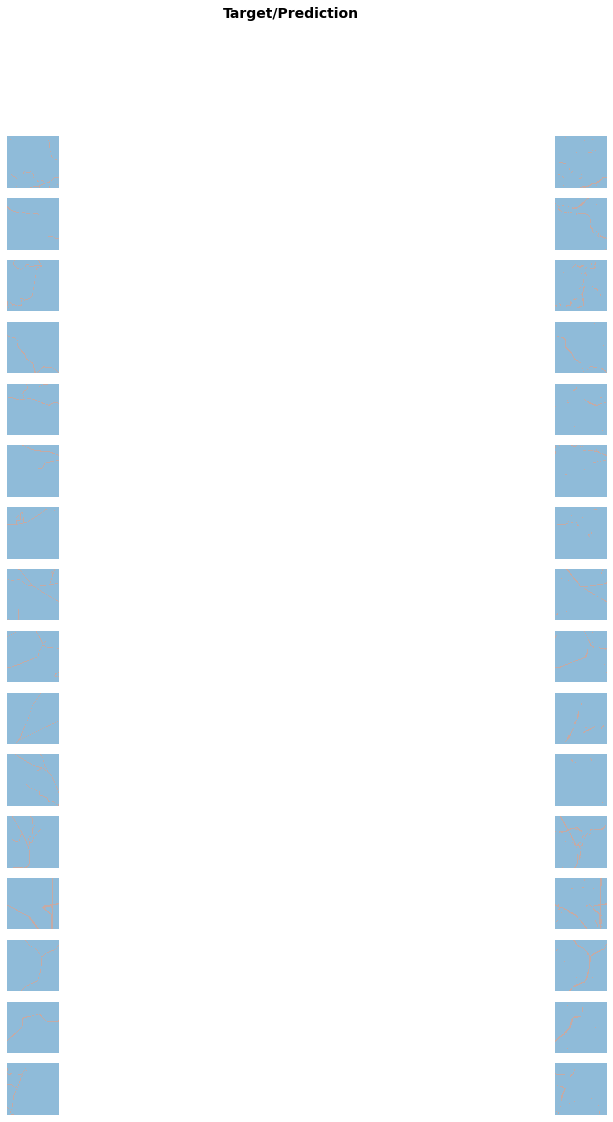

In [78]:
learn.show_results(max_n=20, figsize=(18,18))

Inference

In [79]:
#Load datasets from Drive
!unzip /content/drive/MyDrive/Datasets/PD/ValidImagesS2S1.zip

Archive:  /content/drive/MyDrive/Datasets/PD/ValidImagesS2S1.zip
  inflating: ValidImagesS2S1/osa_106_0.tif  
  inflating: ValidImagesS2S1/osa_108_8.tif  
  inflating: ValidImagesS2S1/osa_109_12.tif  
  inflating: ValidImagesS2S1/osa_11_6.tif  
  inflating: ValidImagesS2S1/osa_127_14.tif  
  inflating: ValidImagesS2S1/osa_129_1.tif  
  inflating: ValidImagesS2S1/osa_13_9.tif  
  inflating: ValidImagesS2S1/osa_134_10.tif  
  inflating: ValidImagesS2S1/osa_14_10.tif  
  inflating: ValidImagesS2S1/osa_141_1.tif  
  inflating: ValidImagesS2S1/osa_141_6.tif  
  inflating: ValidImagesS2S1/osa_151_0.tif  
  inflating: ValidImagesS2S1/osa_151_5.tif  
  inflating: ValidImagesS2S1/osa_158_5.tif  
  inflating: ValidImagesS2S1/osa_159_10.tif  
  inflating: ValidImagesS2S1/osa_166_2.tif  
  inflating: ValidImagesS2S1/osa_168_14.tif  
  inflating: ValidImagesS2S1/osa_168_4.tif  
  inflating: ValidImagesS2S1/osa_169_6.tif  
  inflating: ValidImagesS2S1/osa_186_1.tif  
  inflating: ValidImagesS2S1/osa

In [82]:
inferSet = [fn for fn in sorted((Path('/content/ValidImagesS2S1/')).glob('**/*')) if fn.is_file()]

In [83]:
inferSet[1].name

'osa_108_8.tif'

In [84]:
test_dl = learn.dls.test_dl(inferSet)

In [85]:
preds = learn.get_preds(dl=test_dl)

In [87]:
preds[0].shape

torch.Size([79, 2, 256, 256])

In [88]:
len(codes)

2

In [89]:
pred_1 = preds[0][0]

In [90]:
pred_1.shape

torch.Size([2, 256, 256])

In [91]:
pred_arx = pred_1.argmax(dim=0)

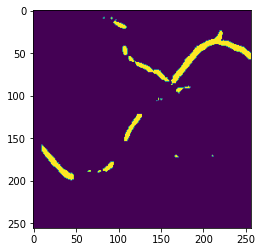

In [92]:
plt.imshow(pred_arx)

In [93]:
pred_arx = pred_arx.numpy()

In [94]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [95]:
im = Image.fromarray(rescaled)

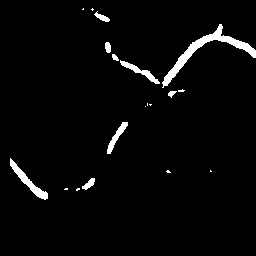

In [96]:
im

In [97]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(str(inferSet[i].name).split('/')[-1])
  # im.save(f'Image_{i}.png')

In [98]:
!mkdir S2S1_val_res

In [99]:
!mv *.tif S2S1_val_res/

In [100]:
!zip -r S2S1_val_res.zip S2S1_val_res/

  adding: S2S1_val_res/ (stored 0%)
  adding: S2S1_val_res/rp_673_5.tif (deflated 99%)
  adding: S2S1_val_res/osa_44_8.tif (deflated 99%)
  adding: S2S1_val_res/osa_151_5.tif (deflated 99%)
  adding: S2S1_val_res/osa_55_12.tif (deflated 99%)
  adding: S2S1_val_res/osa_106_0.tif (deflated 99%)
  adding: S2S1_val_res/rp_171_15.tif (deflated 99%)
  adding: S2S1_val_res/osa_20_10.tif (deflated 99%)
  adding: S2S1_val_res/rp_142_7.tif (deflated 99%)
  adding: S2S1_val_res/rp_107_12.tif (deflated 99%)
  adding: S2S1_val_res/osa_109_12.tif (deflated 98%)
  adding: S2S1_val_res/osa_63_8.tif (deflated 98%)
  adding: S2S1_val_res/osa_190_6.tif (deflated 99%)
  adding: S2S1_val_res/rp_106_1.tif (deflated 99%)
  adding: S2S1_val_res/rp_712_11.tif (deflated 99%)
  adding: S2S1_val_res/rp_170_7.tif (deflated 98%)
  adding: S2S1_val_res/osa_127_14.tif (deflated 98%)
  adding: S2S1_val_res/rp_131_7.tif (deflated 98%)
  adding: S2S1_val_res/osa_151_0.tif (deflated 99%)
  adding: S2S1_val_res/rp_163_13.

In [101]:
from google.colab import files
files.download("S2S1_val_res.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>